In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
sys.path.append("..")

In [4]:
import time
import itertools

import numpy as np
import pandas as pd

from santa.metrics import PerplexityCalculator
from santa.utils import save_text

In [3]:
scorer = PerplexityCalculator("google/gemma-2-9b")

Loading checkpoint shards: 100% 8/8 [00:09<00:00,  1.15s/it]


In [5]:
df = pd.read_csv("./data/sample_submission.csv")
df

,id,text
0,0,advent chimney elf family fireplace gingerbrea...
1,1,advent chimney elf family fireplace gingerbrea...
2,2,yuletide decorations gifts cheer holiday carol...
3,3,yuletide decorations gifts cheer holiday carol...
4,4,hohoho candle poinsettia snowglobe peppermint ...
5,5,advent chimney elf family fireplace gingerbrea...


In [111]:
target_id = 4
if target_id == 0:
    text = "reindeer mistletoe elf gingerbread family advent scrooge chimney fireplace ornament"
elif target_id == 1:
    text = "reindeer sleep walk the night and drive mistletoe scrooge laugh elf jump gingerbread bake ornament give family advent chimney fireplace"
elif target_id == 2:
    text = "sleigh yuletide beard carol cheer chimney decorations gifts grinch holiday holly jingle magi naughty nice nutcracker ornament polar workshop stocking"
elif target_id == 3:
    text = "sleigh of the magi yuletide cheer is unwrap gifts relax and eat cheer decorations carol sing chimney visit workshop grinch holiday holly jingle naughty nice nutcracker polar beard ornament stocking"
elif target_id == 4:
    text = "of and to in the as you that it we with from have not night season eggnog milk chocolate candy peppermint cookie fruitcake toy doll game puzzle greeting card wrapping paper bow wreath poinsettia star angel snowglobe candle fireplace wish dream believe wonder hope joy peace merry hohoho kaggle workshop"
elif target_id == 5:
    text = "from the the the of of and and not and to in is you that it with as advent card angel bake beard believe bow candy carol candle cheer cheer chocolate chimney chimney cookie decorations doll dream drive eat eggnog elf family fireplace fireplace fruitcake game gifts give gingerbread greeting grinch have holiday holly hohoho hope jingle jump joy kaggle laugh magi merry milk mistletoe naughty nice night night nutcracker ornament ornament paper peace peppermint polar poinsettia puzzle reindeer relax scrooge season sing sleigh sleep snowglobe star stocking toy unwrap visit walk we wish wonder workshop workshop wrapping wreath yuletide"

In [112]:
# text = df.loc[0, "text"]
# text

In [113]:
scorer.get_perplexity(text)

67.47986016863359

In [114]:
def text2text(text, sub_texts, sep="-"):
    for st in sub_texts:
        text = text.replace(st, sep.join(st.split()))
    return text


def tokens2text(tokens, sep="-"):
    return " ".join(tokens).replace(sep, " ")


text2text(text, ["advent chimney elf"])

'of and to in the as you that it we with from have not night season eggnog milk chocolate candy peppermint cookie fruitcake toy doll game puzzle greeting card wrapping paper bow wreath poinsettia star angel snowglobe candle fireplace wish dream believe wonder hope joy peace merry hohoho kaggle workshop'

In [120]:
def generate_candidate(text, min_size=2, max_size=10, sep="-"):
    tokens = text.split()
    n = len(tokens)
    if np.random.rand() < 1.0:
        i = np.random.randint(0, n-min_size)
        j = min(n, i + np.random.randint(min_size, max_size))
        s = [] if i == 0 else [sep.join(tokens[:i])]
        m = tokens[i:j]
        e = [] if j == n else [sep.join(tokens[j:])]
        tokens = s + m + e
    else:
        pass
    fix_ids = np.array([i for i, t in enumerate(tokens) if sep in t])
    return tokens, fix_ids


generate_candidate(text)

(['of-and-to-in-the-as-you-that-it-we-with-from-have-not-night-season-eggnog-milk-chocolate-candy-peppermint-cookie-fruitcake-toy-doll-game-puzzle-greeting-card-wrapping-paper-bow-wreath-poinsettia-star-angel-snowglobe-candle-fireplace',
  'wish',
  'dream',
  'believe',
  'wonder',
  'hope',
  'joy',
  'peace',
  'merry',
  'hohoho-kaggle-workshop'],
 array([0, 9]))

In [121]:
def beam_search(init_tokens, fix_ids, scorer, k=30, n_iters=100, precomputed={}, verbose=True):
    n = len(init_tokens)
    candidates = [init_tokens]
    best_score = np.inf
    best_text = None
    top_solutions = {}
    for iterations in range(n_iters):
        start = time.time()
        solutions = {}
        for candidate in candidates:
            for i in range(n):
                if i in fix_ids:
                    continue
                for j in range(i+1, n):
                    if j in fix_ids:
                        continue
                    s = list(candidate).copy()
                    s[i], s[j] = s[j], s[i]
                    s = tuple(s)
                    if s in precomputed:
                        continue
                    text = tokens2text(s)
                    score = scorer.get_perplexity(text)
                    precomputed[s] = score
                    solutions[s] = score
                    if score < best_score:
                        best_score = score
                        best_text = text
                        break
        solutions = sorted(solutions.items(), key=lambda x: x[1])[:k]
        top_solutions.update(solutions)
        if len(solutions) == 0:
            break
        candidates, scores = map(list, zip(*solutions))
        if scores[0] < best_score:
            best_score = scores[0]
            best_text = tokens2text(candidates[0])
        if verbose:
            print(f"[{iterations} iterations] best: {best_score:.3f}, current: {scores[0]:.3f}, top10 mean: {np.mean(scores[:10]):.3f}, elapsed time: {time.time()-start:.1f}[s]")
            print(tokens2text(candidates[0]))
    if best_text is None:
        best_text = tokens2text(init_tokens)
    return best_score, best_text, top_solutions, precomputed

In [ ]:
best_text = text
for i in range(1000):
    init_tokens, fix_ids = generate_candidate(best_text, min_size=8, max_size=15)
    best_score, best_text, top_solutions, precomputed = beam_search(init_tokens, fix_ids, scorer, k=15, n_iters=15, verbose=False)
    print(f"[{i:>03}] {best_score:.3f}\n{best_text}")

In [54]:
scorer.get_perplexity(best_text)

197.63808635335195

In [55]:
best_score

197.63808635335195

In [56]:
best_text

'sleigh of the magi yuletide cheer is unwrap gifts relax and eat cheer decorations carol sing chimney visit workshop grinch holiday holly jingle naughty nice nutcracker polar beard ornament stocking'

In [57]:
tmp = sorted(top_solutions.items(), key=lambda x: x[1])
candidates, scores = map(list, zip(*tmp))
candidates = [tokens2text(candidate) for candidate in candidates]

In [58]:
candidates[0]

'sleigh of the magi yuletide cheer is unwrap gifts relax and eat cheer decorations carol sing chimney visit workshop grinch holiday holly jingle naughty nice nutcracker polar beard ornament stocking'

In [59]:
candidates[1]

'sleigh of the magi yuletide cheer is unwrap gifts and eat cheer decorations sing carol relax chimney visit workshop grinch holiday holly jingle naughty nice nutcracker polar beard ornament stocking'

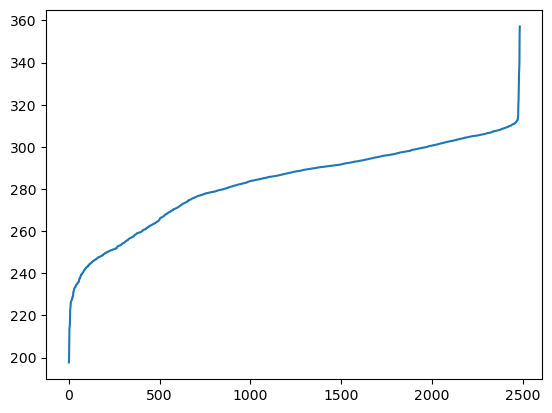

In [60]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(scores)), scores)

In [61]:
import math
from pathlib import Path

output_dir = "./output"
output_dir = Path(output_dir, f"id{target_id}")
output_dir.mkdir(parents=True, exist_ok=True)
for no, (text, score) in enumerate(zip(candidates, scores)):
    f, i = math.modf(score)
    i = int(i)
    f = int(f * 100000)
    with open(Path(output_dir, f"id{target_id}_{no:0>4}_{i:0>4}.{f}.txt"), "w") as f:
        f.write(text)

In [62]:
output_dir = "./output"
save_text(best_text, best_score, target_id, output_dir=output_dir)

sleigh of the magi yuletide cheer is unwrap gifts relax and eat cheer decorations carol sing chimney visit workshop grinch holiday holly jingle naughty nice nutcracker polar beard ornament stocking
